In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# https://stackoverflow.com/questions/27161533/find-the-shortest-distance-between-a-point-and-line-segments-not-line
def dot(v,w):
    x,y,z = v
    X,Y,Z = w
    return x*X + y*Y + z*Z

def length(v):
    x,y,z = v
    return math.sqrt(x*x + y*y + z*z)

def vector(b,e):
    x,y,z = b
    X,Y,Z = e
    return (X-x, Y-y, Z-z)

def unit(v):
    x,y,z = v
    mag = length(v)
    return (x/mag, y/mag, z/mag)

def distance(p0,p1):
    return length(vector(p0,p1))

def scale(v,sc):
    x,y,z = v
    return (x * sc, y * sc, z * sc)

def add(v,w):
    x,y,z = v
    X,Y,Z = w
    return (x+X, y+Y, z+Z)


# Given a line with coordinates 'start' and 'end' and the
# coordinates of a point 'pnt' the proc returns the shortest 
# distance from pnt to the line and the coordinates of the 
# nearest point on the line.
#
# 1  Convert the line segment to a vector ('line_vec').
# 2  Create a vector connecting start to pnt ('pnt_vec').
# 3  Find the length of the line vector ('line_len').
# 4  Convert line_vec to a unit vector ('line_unitvec').
# 5  Scale pnt_vec by line_len ('pnt_vec_scaled').
# 6  Get the dot product of line_unitvec and pnt_vec_scaled ('t').
# 7  Ensure t is in the range 0 to 1.
# 8  Use t to get the nearest location on the line to the end
#    of vector pnt_vec_scaled ('nearest').
# 9  Calculate the distance from nearest to pnt_vec_scaled.
# 10 Translate nearest back to the start/end line. 
# Malcolm Kesson 16 Dec 2012

def pnt2line(pnt, start, end):
    line_vec = vector(start, end)
    pnt_vec = vector(start, pnt)
    line_len = length(line_vec)
    line_unitvec = unit(line_vec)
    pnt_vec_scaled = scale(pnt_vec, 1.0/line_len)
    t = dot(line_unitvec, pnt_vec_scaled)    
    if t < 0.0:
        t = 0.0
    elif t > 1.0:
        t = 1.0
    nearest = scale(line_vec, t)
    dist = distance(nearest, pnt_vec)
    nearest = add(nearest, start)
    return (dist, nearest)

# Plotting a Quiver Plot
This is some code that does shit, stolen from [here](https://stackoverflow.com/questions/26834173/how-do-i-generate-a-vector-field-plot-for-logistic-equation-k-1-using-matplotl).

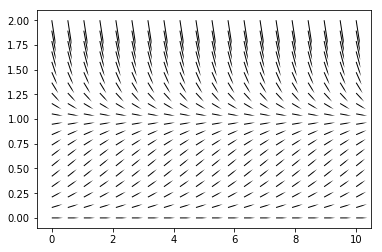

In [3]:
demo_x = np.linspace(0, 10,  20)
demo_y = np.linspace(0 ,2, 20)
demo_X, demo_Y = np.meshgrid(demo_x, demo_y)   # make a grid that roughly matches the Strogatz grid  

demo_dydx = demo_Y*(1-demo_Y)            # the equation of interest
demo_dx = .5*np.ones(demo_Y.shape)  # a constant value (.5 is just so segments don't run into each other -- given spacing of times array
demo_dy = demo_dydx * demo_dx           # given dt, now calc dx for the line segment

plt.quiver(demo_X, demo_Y, demo_dx, demo_dy, headwidth=1, angles='xy', scale=15.)
plt.show()

# Developing the Mission Profile
We want a vector field for the uuv to travel in straight lines between waypoints.

The entire path will be generated at once.

A seperate vector field will be calculated for each waypoint.

## Geometry Setup
Global origin is in the bottom left corner (no negative coordinates).

In [82]:
# define the world grid
x_spacing = 1
y_spacing = 1
max_x = 20
max_y = 20

world_x = np.linspace(1,max_x,max_x*x_spacing)
world_y = np.linspace(1,max_y,max_y*y_spacing)
world_X, world_Y = np.meshgrid(world_x, world_y)

In [83]:
waypoints = [(2,1,0),(2,9,0),(4,9,0),(4,1,0)]  # define the waypoints

In [84]:
def get_steering_vector(curr_x,curr_y,start_point,end_point):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-84-10818a11b893>, line 2)

In [85]:
for current_waypoint_index in range(0,len(waypoints)-2):
    start_point = waypoints[current_waypoint_index]
    end_point = waypoints[current_waypoint_index+1]
    
    

Calculate the vector points based on the closest line point

In [86]:
world_Y

array([[  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
          3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
          4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
          7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.],
       [  8.,   8.,   8.,   8.,   8.,   8

In [92]:
# test basic pathfinding
start_point = (1,1,0)
end_point = (8,12,0)

world_z=[0]
z_crd=0

x_vec_array = []
y_vec_array = []

for y_crd in world_y:
    x_vecs = []
    y_vecs = []
    for x_crd in world_x:
        mod_x, mod_y, mod_z = vector((x_crd,y_crd,z_crd),end_point)
        dist, point = pnt2line((x_crd, y_crd, z_crd), start_point, end_point)
        my_dx = point[0] - x_crd
        my_dy = point[1] - y_crd
        x_vecs.append(my_dx)
        y_vecs.append(my_dy)
    x_vec_array.append(x_vecs)
    y_vec_array.append(y_vecs)
    
            

In [93]:
mission_dx = np.ones(world_X.shape)
mission_dy = np.ones(world_Y.shape)

behavior_dx = mission_dx + x_vec_array
behavior_dy = mission_dy + y_vec_array

In [94]:
pnt2line((4,7,0),(1,4,0),(5,4,0))

(3.0, (4.0, 4.0, 0.0))

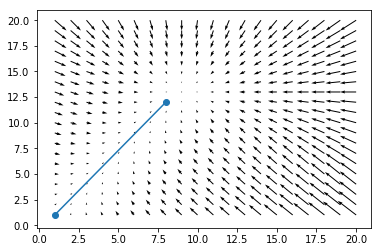

In [95]:
fig, ax = plt.subplots()
ax.quiver(world_X, world_Y, behavior_dx, behavior_dy)
ax.scatter([start_point[0], end_point[0]],[start_point[1],end_point[1]])
ax.plot([start_point[0], end_point[0]],[start_point[1],end_point[1]])
plt.show()

In [65]:
world_Y

array([[  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.],
       [  8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.],
       [  9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.],
       [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.]])

In [36]:
world_X

array([[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]])

In [57]:
fig, ax = plt.subplots()


ax.quiver(world_X, world_Y, path_dx, path_dy)
ax.scatter([start_point[0], end_point[0]],[start_point[1],end_point[1]])
ax.plot([start_point[0], end_point[0]],[start_point[1],end_point[1]])
plt.show()

NameError: name 'path_dx' is not defined

In [ ]:
pnt2line([6,4.6,0],(2,1,0),(3,6,0))[1]